In [14]:
confirmed_api_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_api_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [15]:
import csv
from functools import reduce
from io import StringIO
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy
from scipy import interpolate
%matplotlib inline

In [16]:
confirmed_data = requests.get(confirmed_api_url).content.decode('ascii')
deaths_data = requests.get(deaths_api_url).content.decode('ascii')
all_data = {
    'Confirmed': confirmed_data,
    'Deaths': deaths_data
}

In [17]:
for data_type in all_data:
    lines = []
    reader = csv.reader(
        StringIO(
            all_data[
                data_type
            ]
        )
    )
    for line in reader:
        lines.append(line)
    headers = lines.pop(0)
    all_data[
        data_type
    ] = {
        "headers": headers,
        "data": lines
    } 

In [18]:
for data_type in all_data:
    lines = all_data[
        data_type
    ][
        "data"
    ]
    # Create totals for countries with data by state
    # First get all country names
    countries = set(x[1] for x in lines)
    # For each, does it have multiple entries?
    for country in countries:
        line_count = len(
            list(
                filter(
                    lambda m: m[1] == country and m[0] != "",
                    lines
                )
            )
        )
        has_country_wide_data = 0 < len(
            list(
                filter(
                    lambda m: m[1] == country and m[0] == "",
                    lines
                )
            )
        )
        # If there are records for multiple states
        if line_count > 1 and not has_country_wide_data:
            states = list(
                filter(
                    lambda m: m[1] == country,
                    lines
                )
            )
            new_line = [
                "",
                states[0][1],
                "",   # Don't care about lat/long
                ""    # Don't care about lat/long
            ]
            for i in range(4, len(states[0])):
                total = 0
                for state in states:
                    total += int(state[i])
                new_line.append(total)
            lines.append(new_line)

In [19]:
def delta(numbers):
    deltas = []
    for i in range(len(numbers) - 1):
        deltas.append(
            numbers[i + 1] - numbers[i]
        )
    return deltas

def n_day_average(
    n, 
    numbers
):
    averages = []
    for i in range(len(numbers)):
        end_index = i + n
        if (i + n) > len(numbers):
            end_index = len(numbers)
        to_average = numbers[i:end_index]
        averages.append(
            reduce(
                lambda x, y: x + y,
                to_average
            ) / len(to_average)
        )
    return averages

def double_delta(numbers):
    return delta(
        delta(
            numbers
        )
    )

In [20]:
# Settings
data_type = 'Confirmed'
n_average = 5

# Function to create plots
def plots(
    data_type,
    target_country,
    target_region,
    n_average
):
    lines = all_data[
        data_type
    ][
        "data"
    ]
    headers = all_data[
        data_type
    ][
        "headers"
    ]
    target_row = list(
        filter(
            lambda m: m[1] == target_country,
            lines
        )
    )
    target_row = list(
        filter(
            lambda m: m[0] == target_region,
            target_row
        )
    )
    dates = headers[4:]
    first_date = dates[0].split("/")
    first_date = "20" + first_date[-1] + "-" + ("000" + first_date[0])[-2:] + "-" + first_date[1]
    numbers = [int(x) for x in target_row[0][4:]]
    changes = delta(numbers)
    accelerations = double_delta(numbers)
    averages = n_day_average(
        n_average, 
        numbers
    )
    average_changes = n_day_average(
        n_average,
        changes
    )
    average_accelerations = n_day_average(
        n_average,
        accelerations
    )
    for inline in [True, False]:
        fig = plt.figure()
        # Raw data plot
        plt.scatter(
            dates,
            numbers
        )
        # Delete every n dates, for readability
        n_keep = 4
        ticks = plt.gca().xaxis.get_ticklabels()
        for tick in ticks:
            if ticks.index(tick) % n_keep == 0:
                tick.set_visible(True)
            else:
                tick.set_visible(False)
        _ = plt.ylim(
            [
                1, 
                max(numpy.array(numbers) * 1.25)
            ]
        )
        plt.xticks(rotation=90)
        plt.title(target_country)
        plt.xlabel("Date")
        plt.ylabel(data_type + ", no averaging")
        if inline:
            plt.show()
        else:
            fig.savefig(
                target_country + "-raw.png",
                bbox_inches='tight'
            )
    # Averaged cases
        fig = plt.figure()
        plt.scatter(
            range(
                len(
                    averages
                )
            ), 
            averages
        )
        x_label_text = "Days since " + first_date
        plt.xlabel(x_label_text)
        plt.ylabel(data_type + ", running average")
        plt.title(target_country)
        if inline:
            plt.show()
        else:
            plt.savefig(
                target_country + "-averaged.png",
                bbox_inches='tight'
            )
        # Change in cases per day ('velocity')
        fig = plt.figure()
        plt.scatter(
            range(
                len(
                    average_changes
                )
            ), 
            average_changes
        )
        plt.xlabel(x_label_text)
        plt.ylabel(data_type + ", change, cases/day")
        plt.title(target_country)
        if inline:
            plt.show()
        else:
            plt.savefig(
                target_country + "-velocity.png",
                bbox_inches='tight'
            )
        # Change in change in cases per date ('acceleration')
        fig = plt.figure()
        plt.scatter(
            range(
                len(
                    average_accelerations
                )
            ), 
            average_accelerations
        )
        plt.xlabel(x_label_text)
        plt.ylabel(
            data_type + ", acceleration, cases/day^2"
        )
        plt.title(target_country)
        plt.tight_layout()
        if inline:
            plt.show()
        else:
            plt.gcf().savefig(
                target_country + "-acceleration.png",
                bbox_inches='tight'
            )

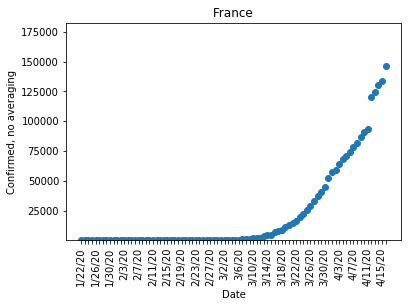

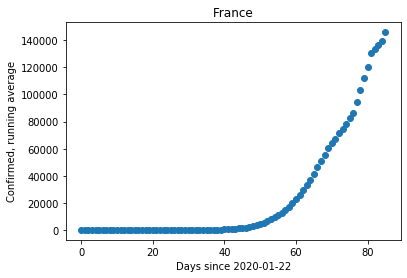

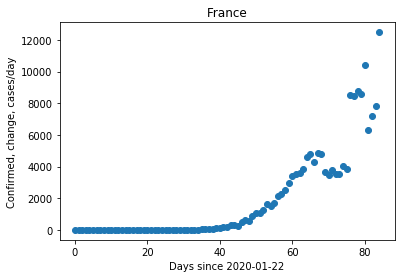

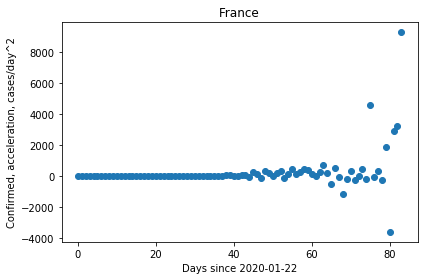

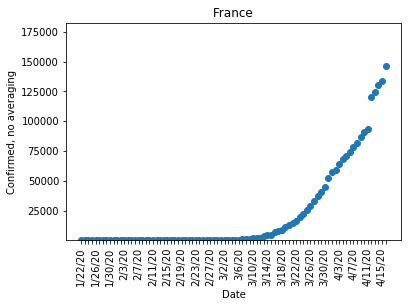

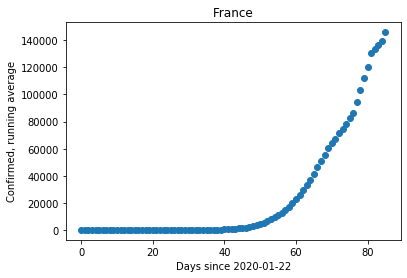

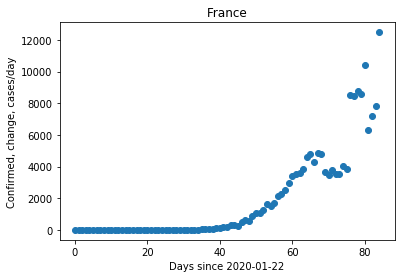

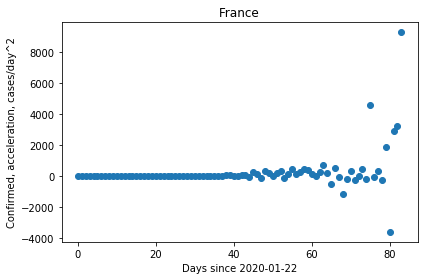

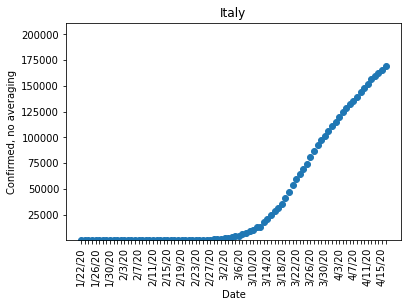

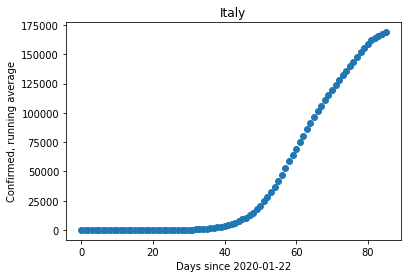

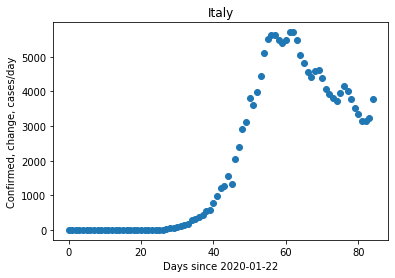

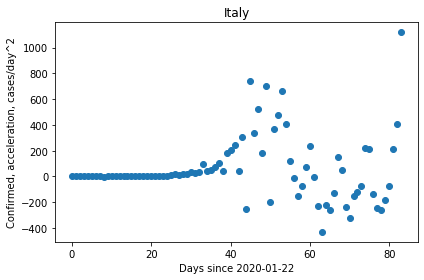

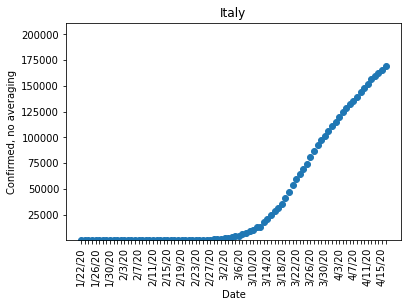

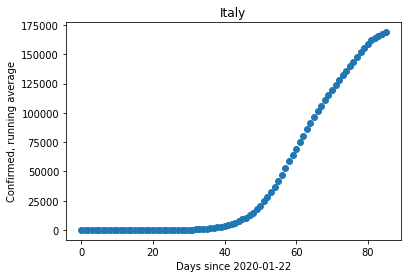

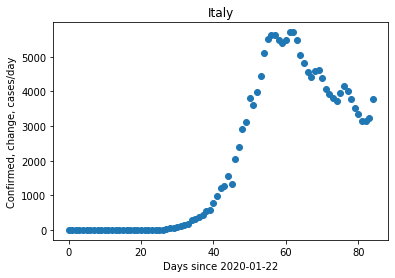

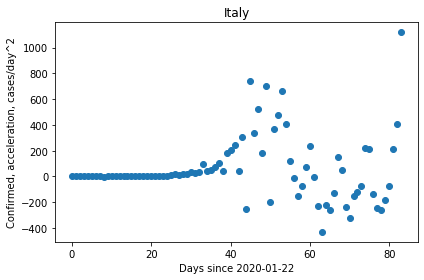

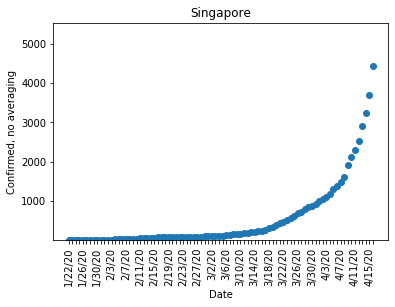

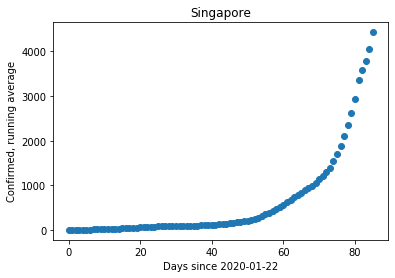

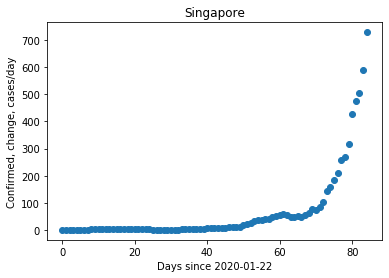

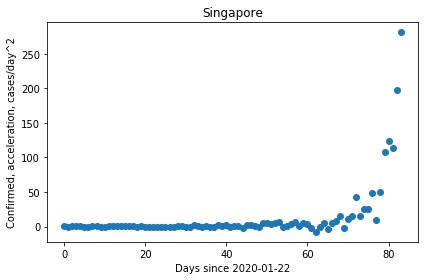

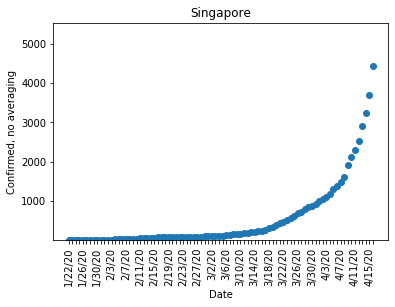

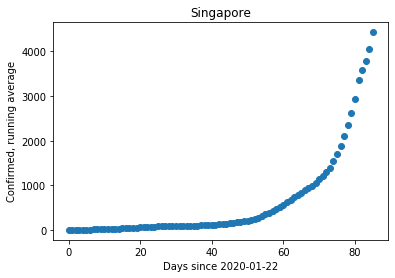

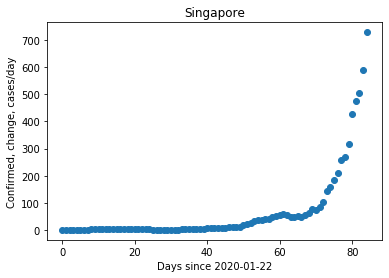

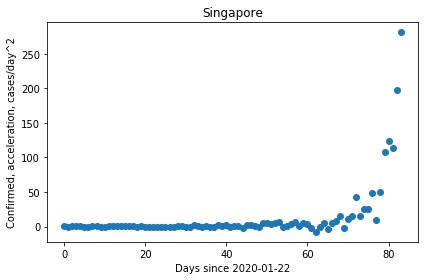

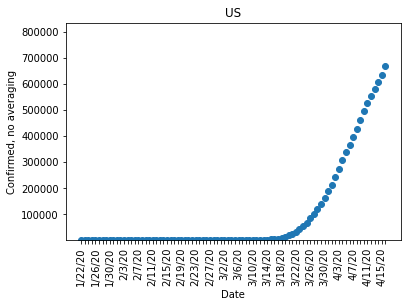

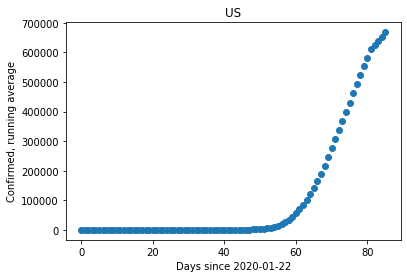

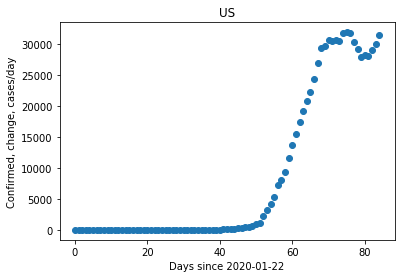

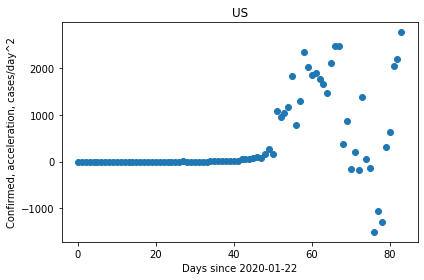

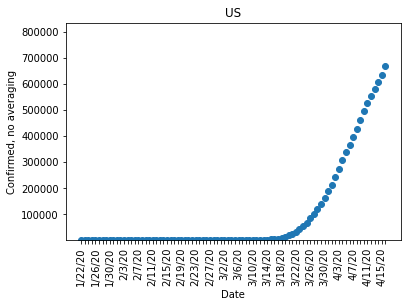

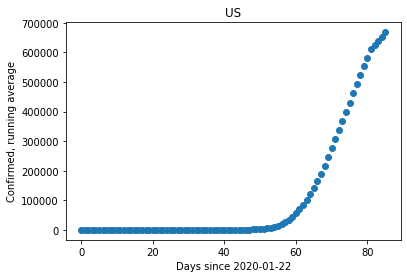

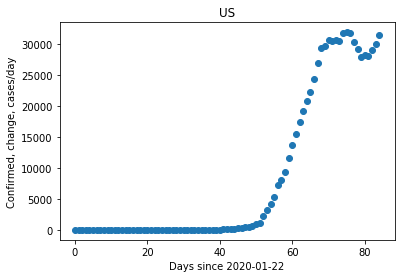

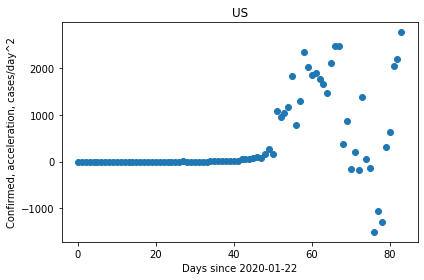

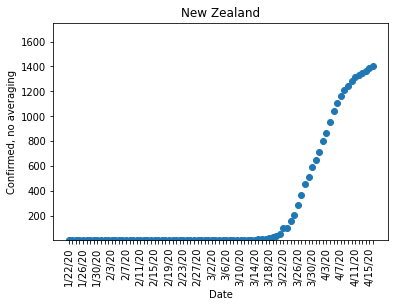

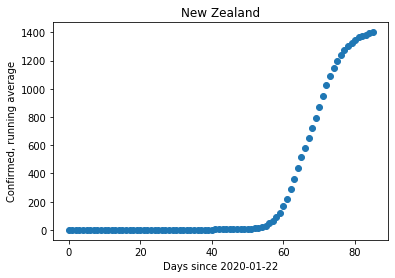

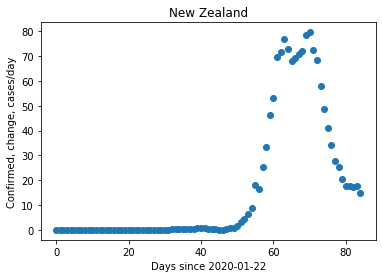

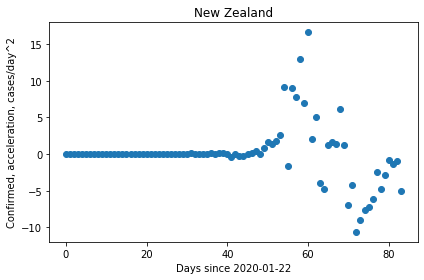

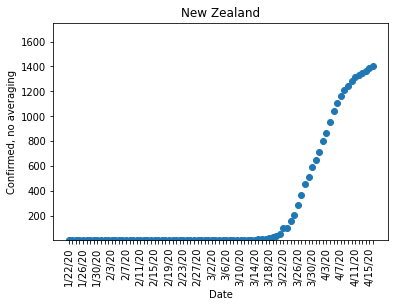

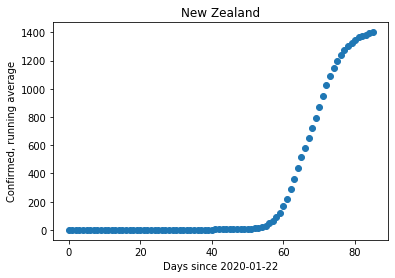

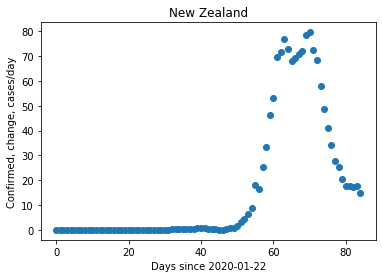

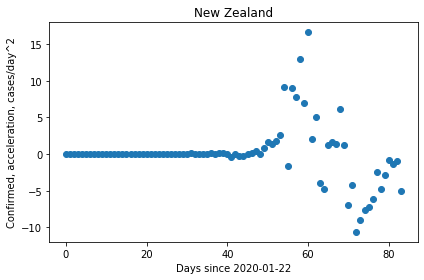

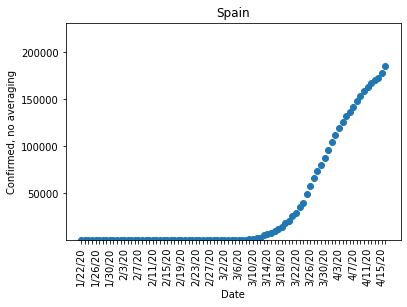

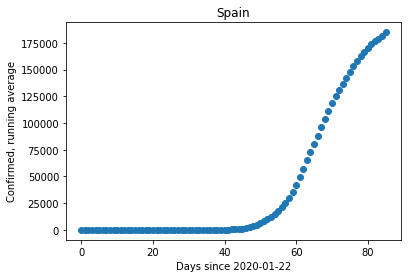

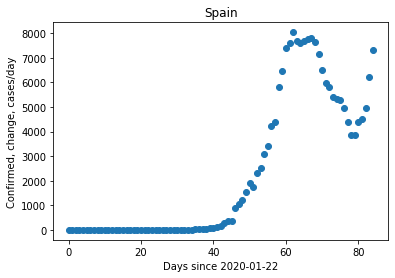

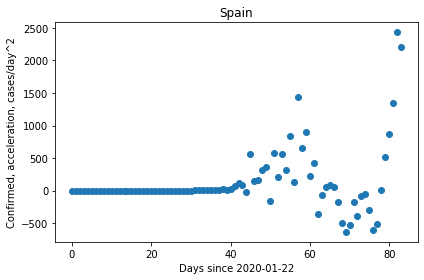

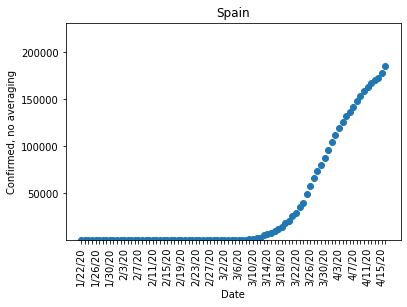

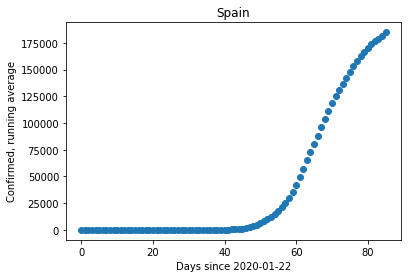

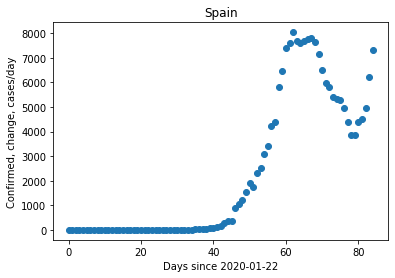

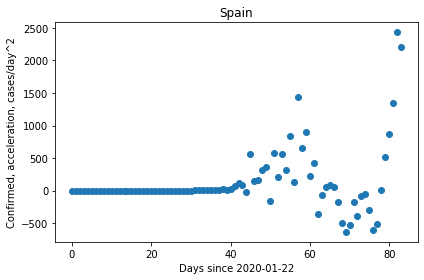

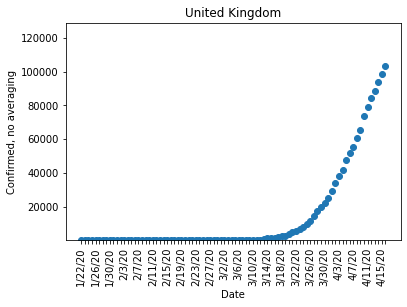

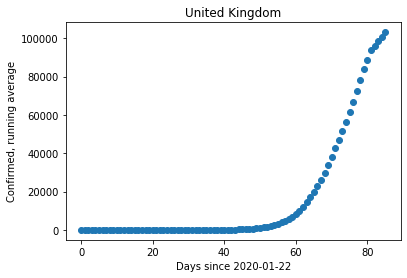

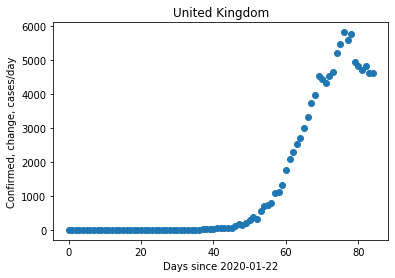

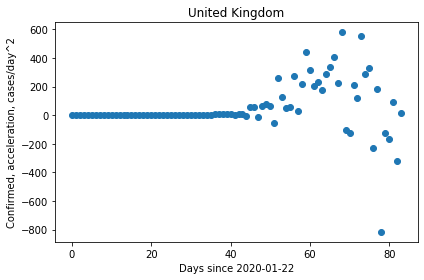

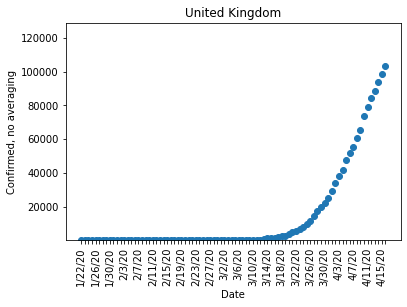

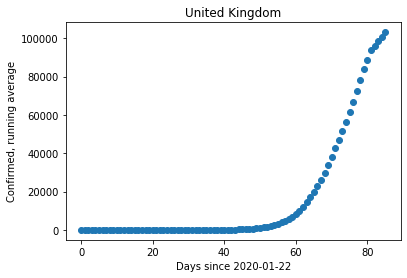

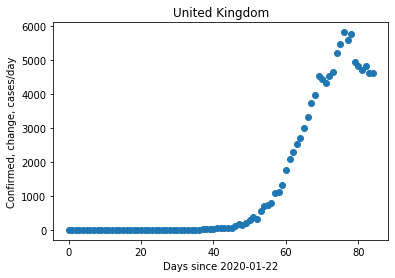

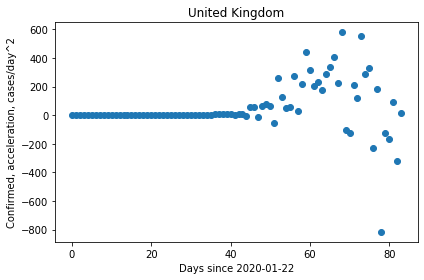

In [21]:
countries = [
    "France",
    "Italy",
    "Singapore",
    "US",
    "New Zealand",
    "Spain",
    "United Kingdom"
]
for country in countries:
    plots(
        data_type,
        country,
        "",
        n_average
    )